## Problem Statement
What should the TFI company take into consideration when investing on a new restaurant that is highly profitable.

Data dictionnary
1. `Id` : Restaurant id.
2. `Open Date` : opening date for a restaurant
3. `City` : City that the restaurant is in. Note that there are unicode in the names.
4. `City Group` : Type of the city. Big cities, or Other.
5. `Type` : Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
6. `P1`, `P2` - `P37` : There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
7. `Revenue` : The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values.

### _Imports_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNetCV, ElasticNet
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,confusion_matrix,mean_absolute_percentage_error,mean_squared_log_error
from sklearn.pipeline import Pipeline


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
test = pd.read_csv('./data/test.csv')

### _Reading the Data_

In [4]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [5]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [6]:
train.dtypes

Id              int64
Open Date      object
City           object
City Group     object
Type           object
P1              int64
P2            float64
P3            float64
P4            float64
P5              int64
P6              int64
P7              int64
P8              int64
P9              int64
P10             int64
P11             int64
P12             int64
P13           float64
P14             int64
P15             int64
P16             int64
P17             int64
P18             int64
P19             int64
P20             int64
P21             int64
P22             int64
P23             int64
P24             int64
P25             int64
P26           float64
P27           float64
P28           float64
P29           float64
P30             int64
P31             int64
P32             int64
P33             int64
P34             int64
P35             int64
P36             int64
P37             int64
revenue       float64
dtype: object

In [7]:
train['revenue'].describe()

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64

In [8]:
test.shape

(100000, 42)

In [9]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


### _Data Cleaning_

In [10]:
def missing_values(data): # function to check missing value 
        mis_total = data.isnull().sum()
        mis_pct = 100 * data.isnull().sum() / len(data)
        mis_value_table = pd.concat([mis_total, mis_pct], axis = 1)
        mis_value_table_columns = mis_value_table.rename(columns = {0 : 'No. of Missing Value', 1 : '% of Total Missing Value'})
        
        mis_value_table_columns = mis_value_table_columns[mis_value_table_columns.iloc[:,1] != 0].sort_values('% of Total Missing Value', ascending = False).round(2)
        return mis_value_table_columns

In [11]:
missing_values(train)

,No. of Missing Value,% of Total Missing Value


In [12]:
missing_values(test) # No missing values on testing data. 

,No. of Missing Value,% of Total Missing Value


In [13]:
train['Open Date'] = pd.to_datetime(train['Open Date'])

In [14]:
test['Open Date'] = pd.to_datetime(test['Open Date'])

In [15]:
train['year'] = train['Open Date'].dt.year

In [16]:
test['year'] = test['Open Date'].dt.year

In [17]:
train['month'] = train['Open Date'].dt.month

In [18]:
test['month'] = test['Open Date'].dt.month

In [19]:
lookup = {
    11: 'Winter',
    12: 'Winter',
    1: 'Winter',
    2: 'Spring',
    3: 'Spring',
    4: 'Spring',
    5: 'Summer',
    6: 'Summer',
    7: 'Summer',
    8: 'Fall',
    9: 'Fall',
    10: 'Fall'
}

In [20]:
train['season'] = train['Open Date'].apply(lambda x : lookup[x.month])

In [21]:
test['season'] = test['Open Date'].apply(lambda x : lookup[x.month])

In [22]:
train['City Group'].unique() 

array(['Big Cities', 'Other'], dtype=object)

In [23]:
train['City'].nunique()

34

In [24]:
test['City'].nunique()

57

In [25]:
train.drop('City', axis = 1, inplace = True)
test.drop('City', axis = 1, inplace = True)

##### _The `test` data has way more unique values than train data. Thus, the `City` feature will be less useful for any model_

In [26]:
train['Type'].unique()

array(['IL', 'FC', 'DT'], dtype=object)

In [27]:
test['Type'].unique()

array(['FC', 'IL', 'DT', 'MB'], dtype=object)

In [28]:
test.loc[test['Type'] == 'MB', 'Type'] = 'DT'

##### _In the `train` dataset, there is no such `Type` as `MB` as in the `test` data. The `MB` stands as mobile which similar to the `DT` in nature. we will change `MB` to `DT` for better predictions._

In [29]:
train['revenue'].describe()

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64

In [30]:
test['Type'].unique()

array(['FC', 'IL', 'DT'], dtype=object)

In [31]:
train.drop(columns = ['Id', 'Open Date','month'], inplace = True) # dropping ID and open date in the training data as it will not be necessary. 

In [32]:
test.drop(columns = ['Open Date','month'], inplace = True) # dropping ID and open date in the testing data

In [33]:
train.head()

,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,...,P31,P32,P33,P34,P35,P36,P37,revenue,year,season
0,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,...,3,4,5,5,4,3,4,5653753.0,1999,Summer
1,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,...,0,0,0,0,0,0,0,6923131.0,2008,Spring
2,Other,IL,2,4.0,2.0,5.0,2,3,5,5,...,0,0,0,0,0,0,0,2055379.0,2013,Spring
3,Other,IL,6,4.5,6.0,6.0,4,4,10,8,...,12,10,6,18,12,12,6,2675511.0,2012,Spring
4,Other,IL,3,4.0,3.0,4.0,2,2,5,5,...,1,3,2,3,4,3,3,4316715.0,2009,Summer


### _EDA_

In [34]:
con_var = []
dis_var = []
var_unique = train.nunique()
for var,var_num in enumerate(var_unique):
    if var_num>50:
        con_var.append(var)
    else:
        dis_var.append(var)

con_columns=[train.columns[i] for i in con_var ]
dis_columns=[train.columns[i] for i in dis_var ]

In [35]:
dis_columns

['City Group',
 'Type',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P24',
 'P25',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P34',
 'P35',
 'P36',
 'P37',
 'year',
 'season']

<AxesSubplot:>

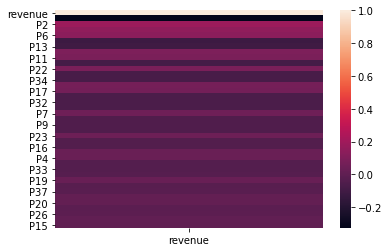

In [36]:
sns.heatmap(train.corr()[['revenue']].sort_values(by = 'revenue', key = abs, ascending = False))

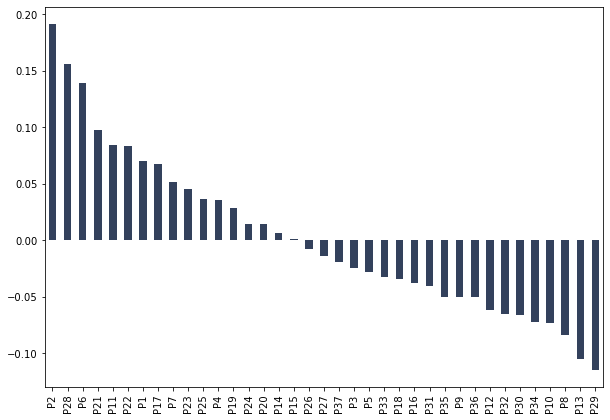

In [37]:
revenue_corr = train.drop(['City Group','Type','year'],axis=1).corr()['revenue'].sort_values(ascending=False)
plt.figure(figsize=(10,7))
revenue_corr.drop('revenue').plot.bar(color = '#33415C')
plt.show();

In [38]:
dis_columns.append('revenue') 

In [39]:
spearman = train[dis_columns].corr(method ='spearman') # Spearman Corrlations. No Strong corrlations have been identified 
spearman_corr = spearman['revenue'].sort_values(ascending = False)
spearman_corr

revenue    1.000000
P28        0.312546
P2         0.256816
P1         0.231995
P6         0.225137
P21        0.205224
P20        0.139311
P17        0.124630
P7         0.123679
P23        0.120974
P25        0.115898
P19        0.106200
P14        0.096887
P24        0.094468
P11        0.091662
P36        0.089499
P26        0.089063
P18        0.086527
P37        0.084253
P15        0.081093
P16        0.079581
P35        0.077735
P22        0.075532
P31        0.075095
P27        0.075008
P34        0.072422
P33        0.070216
P30        0.060424
P32        0.059489
P4         0.043871
P3         0.027661
P9         0.019553
P12        0.018897
P5        -0.017929
P8        -0.034094
P13       -0.048885
P29       -0.048981
P10       -0.049512
year      -0.330274
Name: revenue, dtype: float64

In [40]:
train[dis_columns].apply(pd.Series.nunique, axis = 0) # defining number of unique values in each discrete column 

City Group      2
Type            3
P1              8
P2              8
P3              8
P4              6
P5              7
P6              8
P7              6
P8              8
P9              4
P10             4
P11             8
P12             7
P13             5
P14            10
P15             8
P16             9
P17             9
P18             7
P19             9
P20             9
P21             8
P22             5
P23             9
P24             9
P25             8
P26            10
P27             9
P28             9
P29             7
P30             9
P31            10
P32            10
P33             6
P34             8
P35             8
P36             8
P37             8
year           17
season          4
revenue       137
dtype: int64

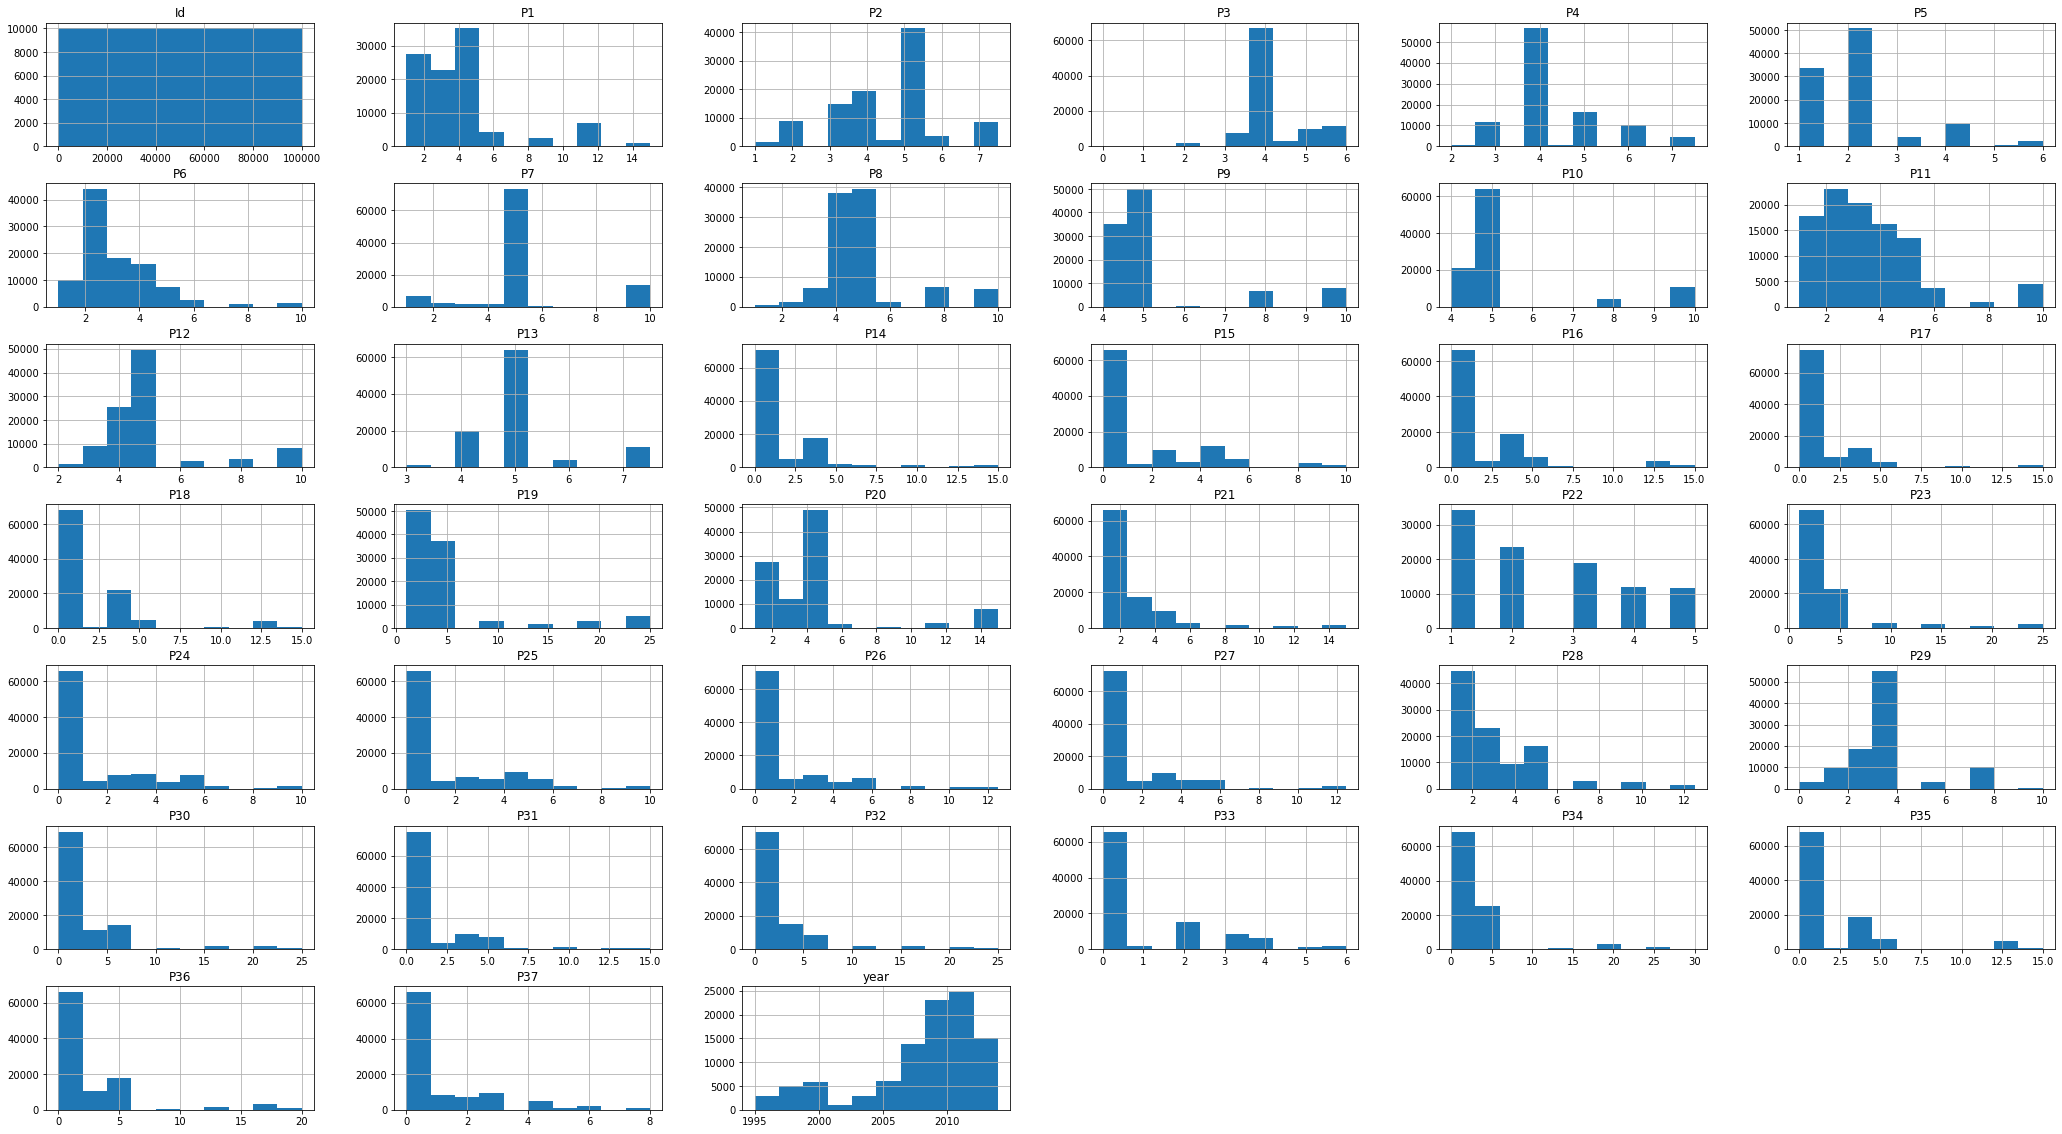

In [41]:
test.hist(figsize = (36,20));

In [42]:
#plt.figure(figsize = (20, 12))
#sns.scatterplot(x="revenue", y="City",s=35, alpha = 0.6,data=train)

In [43]:
train['revenue'].max() # define the max which helps to find the outliers shows above 

19696939.0

In [44]:
index_drop1 = train[train['revenue'] == 19696939.0].index # dropping outliers 
train.drop(index_drop1, inplace = True)

In [45]:
index_drop2 = train[train['revenue'] == 16549064.0].index # dropping outliers 
train.drop(index_drop2, inplace = True)

In [46]:
index_drop3 = train[train['revenue'] == 13575224.0].index # dropping outliers
train.drop(index_drop3, inplace = True)

C:\Users\irene\anaconda3\envs\dsirfx_py38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Revenue Distribution (Train Data)')

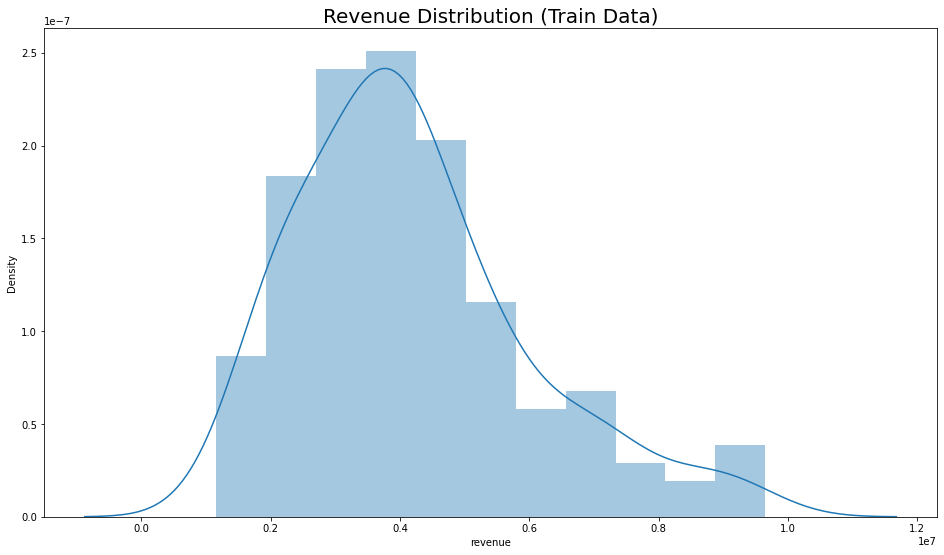

In [47]:
plt.figure (figsize = (16, 9))
sns.distplot(train['revenue'] )
plt.title('Revenue Distribution (Train Data)', fontdict={'fontsize':20})

In [48]:
train['revenue'] = np.log1p(train['revenue']) # log transformation. 

C:\Users\irene\anaconda3\envs\dsirfx_py38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log Transformation Revenue Distribution (Train Data)')

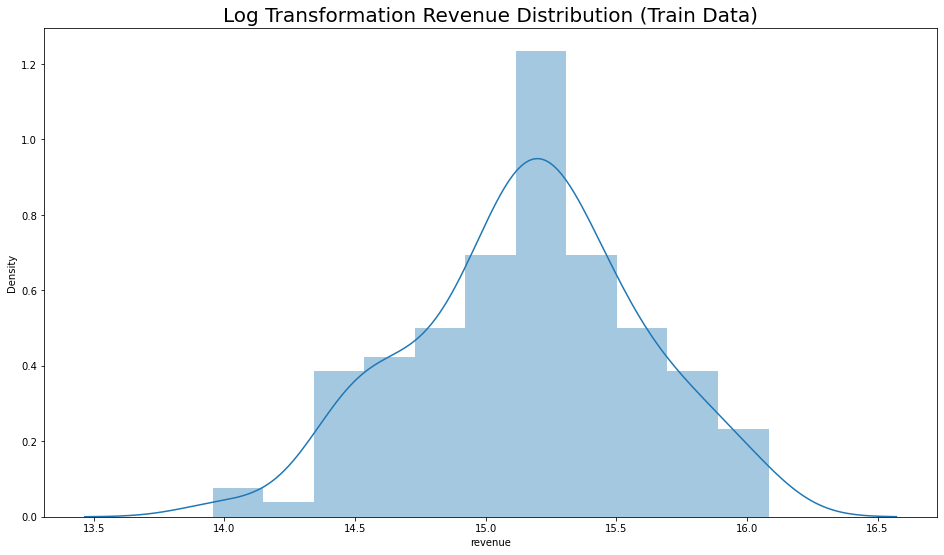

In [49]:
plt.figure (figsize = (16, 9))
sns.distplot(train['revenue'])
plt.title('Log Transformation Revenue Distribution (Train Data)', fontdict={'fontsize':20})

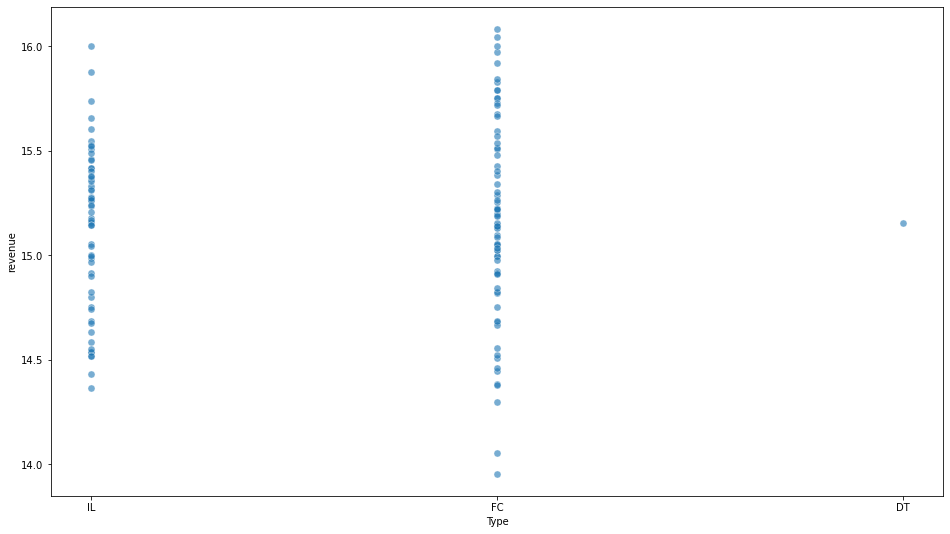

In [50]:
plt.figure (figsize = (16, 9))
fig = sns.scatterplot(x="Type", y="revenue",s=50, alpha = 0.6,data=train);

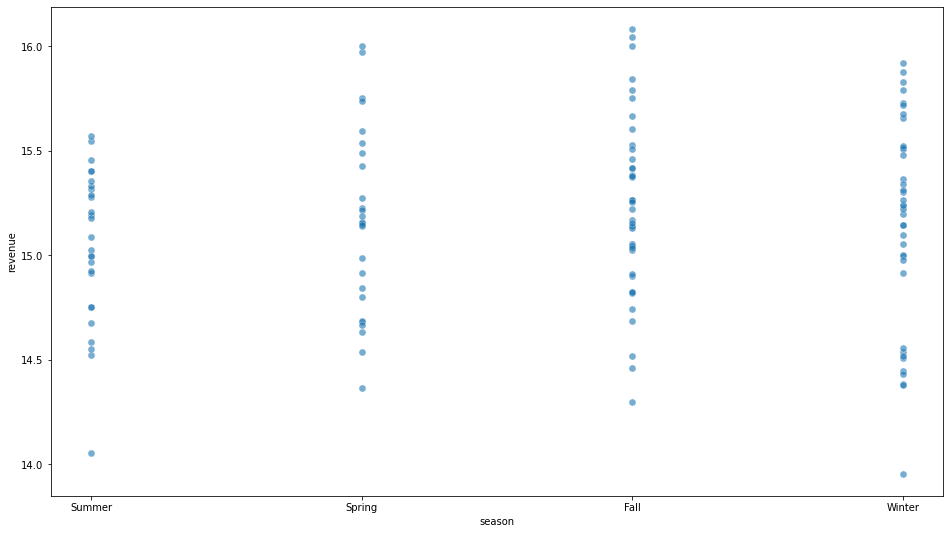

In [51]:
plt.figure (figsize = (16, 9))
fig = sns.scatterplot(x="season", y="revenue",s=50, alpha = 0.6,data=train);

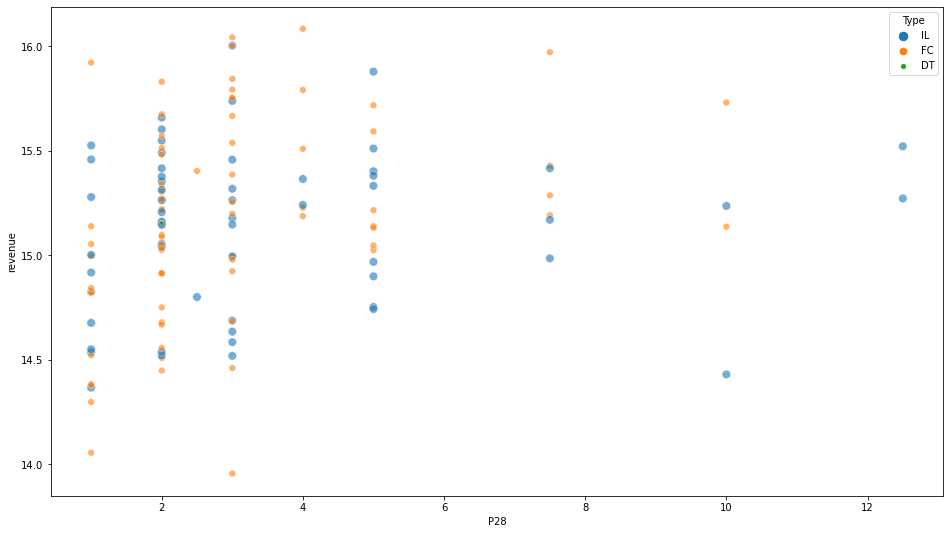

In [52]:
plt.figure (figsize = (16, 9))
fig = sns.scatterplot(x="P28", y="revenue",s=50,hue="Type", size = 'Type', alpha = 0.6,data=train);

In [147]:
plt.figure (figsize = (16, 9))
fig = sns.scatterplot(x="year", y="revenue",s=50,hue="Type", size = 'revenue', alpha = 0.6,data=train);
plt.title('Revenue in each Restaurant over the open year   (by type )', fontdict={'fontsize':20})

ValueError: Could not interpret value `Type` for parameter `hue`

<Figure size 1152x648 with 0 Axes>

Text(0.5, 1.0, 'Train Number of Restaurant in each Restaurant Type (by City Group)')

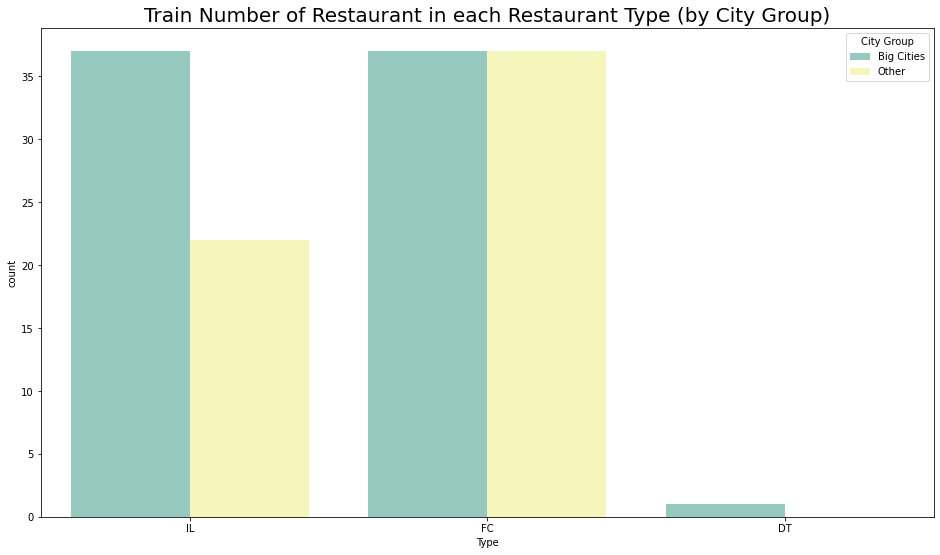

In [54]:
plt.figure (figsize = (16, 9))
sns.countplot(x = 'Type',hue ='City Group', data = train, palette='Set3')
plt.title('Train Number of Restaurant in each Restaurant Type (by City Group)', fontdict={'fontsize':20})

Text(0.5, 1.0, 'Test Data Number of Restaurant in each Restaurant Type (by City Group)')

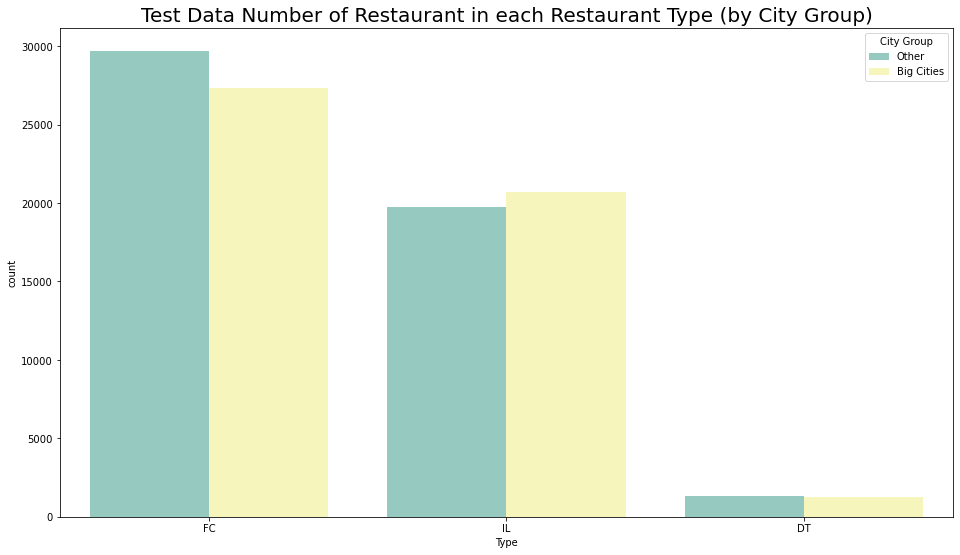

In [55]:
plt.figure (figsize = (16, 9))
sns.countplot(x = 'Type',hue ='City Group', data = test, palette='Set3')
plt.title('Test Data Number of Restaurant in each Restaurant Type (by City Group)', fontdict={'fontsize':20})

Text(0.5, 1.0, 'Number of Restaurants Opened in each Season (by City Group / Train Data)')

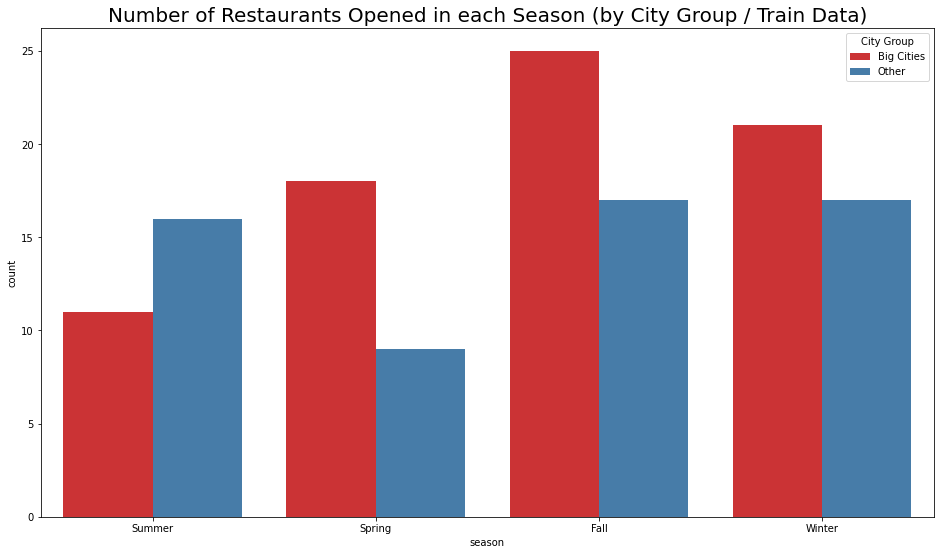

In [56]:
plt.figure (figsize = (16, 9))
sns.countplot(x = 'season',hue ='City Group', data = train, palette='Set1')
plt.title('Number of Restaurants Opened in each Season (by City Group / Train Data)', fontdict={'fontsize':20})

Text(0.5, 1.0, 'Number of Restaurants Opened in each Season (by City Group / Test Data)')

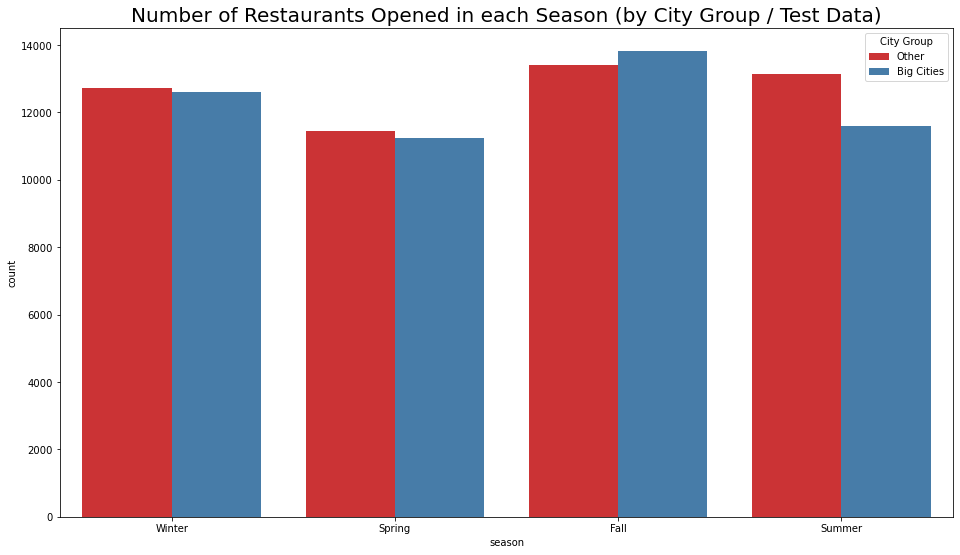

In [57]:
plt.figure (figsize = (16, 9))
sns.countplot(x = 'season',hue ='City Group', data = test, palette='Set1')
plt.title('Number of Restaurants Opened in each Season (by City Group / Test Data)', fontdict={'fontsize':20})

### _Modeling_ 

##### _Pre-Processing_

In [58]:
columns_to_dummy = train.select_dtypes(include = ['object']).columns
train = pd.get_dummies(train, columns = columns_to_dummy, drop_first = False)
test = pd.get_dummies(test, columns = columns_to_dummy, drop_first = False)

In [59]:
train.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,year,City Group_Big Cities,City Group_Other,Type_DT,Type_FC,Type_IL,season_Fall,season_Spring,season_Summer,season_Winter
0,4,5.0,4.0,4.0,2,2,5,4,5,5,...,1999,1,0,0,0,1,0,0,1,0
1,4,5.0,4.0,4.0,1,2,5,5,5,5,...,2008,1,0,0,1,0,0,1,0,0
2,2,4.0,2.0,5.0,2,3,5,5,5,5,...,2013,0,1,0,0,1,0,1,0,0
3,6,4.5,6.0,6.0,4,4,10,8,10,10,...,2012,0,1,0,0,1,0,1,0,0
4,3,4.0,3.0,4.0,2,2,5,5,5,5,...,2009,0,1,0,0,1,0,0,1,0


In [60]:
train.shape

(134, 48)

In [61]:
test.shape

(100000, 48)

In [62]:
X, y = train.drop('revenue', axis=1), train['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### _Baseline Model - Linear Regression_

In [63]:
lr = LinearRegression ()

In [64]:
lr.fit(X_train, y_train)

LinearRegression()

In [65]:
lr.score(X_train, y_train)

0.5741578207986675

In [66]:
lr.score(X_test, y_test) # 

-0.9253147916721598

In [67]:
mean_squared_error(y_train, lr.predict(X_train))

0.07727318342558295

In [68]:
mean_squared_error(y_test, lr.predict(X_test))

0.38668126007640324

In [69]:
y_pred = lr.predict(X_test)

In [70]:
print('Explained variance score',explained_variance_score(y_test, y_pred),'\n',
   'Mean absolute error      :',mean_absolute_error(y_test, y_pred),'\n',
   'Mean squared error       :',mean_squared_error(y_test, y_pred),'\n',
   'R² score            :',r2_score(y_test, y_pred))

Explained variance score -0.9218765327162419 
 Mean absolute error      : 0.488084351581609 
 Mean squared error       : 0.38668126007640324 
 R² score            : -0.9253147916721598


In [71]:
score_df_lr = pd.DataFrame(columns=['Method','Linear Regression'])
score_df_lr['Method']=[
                    'Mean Absolute Error',
                    'Mean Squared Error',
                    'RMSE',
                    'R²']
score_df_lr['Linear Regression']=[
                   mean_absolute_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred, squared = False),
                   r2_score(y_test, y_pred)]

In [72]:
score_df_lr

,Method,Linear Regression
0,Mean Absolute Error,0.488084
1,Mean Squared Error,0.386681
2,RMSE,0.621837
3,R²,-0.925315


#### _Lasso Regression_

In [73]:
params_lasso = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],}

In [74]:
lasso = Lasso()

In [75]:
lasso_regressor = GridSearchCV(lasso, params_lasso, cv=5, n_jobs=8)

In [76]:
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=8,
             param_grid={'alpha': [0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 5,
                                   10, 20]})

In [77]:
lasso_regressor.best_params_

{'alpha': 0.5}

In [78]:
lasso_model = Lasso(alpha = 0.5)

In [79]:
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.5)

In [80]:
lasso_model.score(X_train, y_train)

0.0

In [81]:
lasso_model.score(X_test, y_test)

-0.0007943878764755663

In [82]:
y_pred = lasso_model.predict(X_test)

In [83]:
print('Explained variance score',explained_variance_score(y_test, y_pred),'\n',
   'Mean absolute error      :',mean_absolute_error(y_test, y_pred),'\n',
   'Mean squared error       :',mean_squared_error(y_test, y_pred),'\n',
   'R² score            :',r2_score(y_test, y_pred))

Explained variance score 0.0 
 Mean absolute error      : 0.34410784208789436 
 Mean squared error       : 0.2010000840669613 
 R² score            : -0.0007943878764755663


In [84]:
score_df_lasso = pd.DataFrame(columns=['Method','Lasso Regression'])
score_df_lasso['Method']=[
                    'Mean Absolute Error',
                    'Mean Squared Error',
                    'RMSE',
                    'R²']
score_df_lasso['Lasso Regression']=[
                   mean_absolute_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred, squared = False),
                   r2_score(y_test, y_pred)]

In [85]:
score_df_lasso

,Method,Lasso Regression
0,Mean Absolute Error,0.344108
1,Mean Squared Error,0.201000
2,RMSE,0.448330
3,R²,-0.000794


#### _Ridge Regression_

In [86]:
ridge = Ridge()

In [87]:
params_ridge = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [88]:
ridge_regressor = GridSearchCV(ridge, params_ridge,cv=5, n_jobs=-1)

In [89]:
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 5,
                                   10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']})

In [90]:
ridge_regressor.best_params_

{'alpha': 20, 'solver': 'saga'}

In [91]:
ridge_model = Ridge(alpha = 20,
                    solver = 'saga')

In [92]:
ridge_model.fit(X_train, y_train)

Ridge(alpha=20, solver='saga')

In [93]:
ridge_model.score(X_train, y_train)

0.4374985578229389

In [94]:
ridge_model.score(X_test, y_test)

-0.0833763385225692

In [95]:
y_pred = ridge_model.predict(X_test)

In [96]:
print('Explained variance score',explained_variance_score(y_test, y_pred),'\n',
   'Mean absolute error      :',mean_absolute_error(y_test, y_pred),'\n',
   'Mean squared error       :',mean_squared_error(y_test, y_pred),'\n',
   'R² score            :',r2_score(y_test, y_pred))

Explained variance score -0.07028547285383291 
 Mean absolute error      : 0.37721430003775136 
 Mean squared error       : 0.21758588752804872 
 R² score            : -0.0833763385225692


In [97]:
score_df_ridge = pd.DataFrame(columns=['Method','Ridge Regression'])
score_df_ridge['Method']=[
                    'Mean Absolute Error',
                    'Mean Squared Error',
                    'RMSE',
                    'R²']
score_df_ridge['Ridge Regression']=[
                   mean_absolute_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred, squared = False),
                   r2_score(y_test, y_pred)]

In [98]:
score_df_ridge

,Method,Ridge Regression
0,Mean Absolute Error,0.377214
1,Mean Squared Error,0.217586
2,RMSE,0.466461
3,R²,-0.083376


#### _Random Forest Regressor_

In [99]:
params_rf = {
    'max_depth': [None, 1, 5, 10, 30, 35],
    'max_features': [.1, .2, .3],
    'n_estimators': [200, 300, 400,500]
}

In [100]:
rf = RandomForestRegressor()

In [101]:
rf_regressor = GridSearchCV(rf, params_rf,cv = 10, n_jobs = -1)

In [102]:
rf_regressor.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 5, 10, 30, 35],
                         'max_features': [0.1, 0.2, 0.3],
                         'n_estimators': [200, 300, 400, 500]})

In [103]:
rf_regressor.best_params_

{'max_depth': 30, 'max_features': 0.1, 'n_estimators': 300}

In [104]:
rf_model = RandomForestRegressor(max_depth = 65,
                                 max_features = 0.3,
                                 n_estimators = 30)

In [105]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=65, max_features=0.3, n_estimators=30)

In [106]:
rf_model.score(X_train, y_train)

0.8643578981190003

In [107]:
rf_model.score(X_test, y_test)

0.13429933645667402

In [108]:
y_pred = rf_model.predict(X_test)

In [109]:
print('Explained variance score',explained_variance_score(y_test, y_pred),'\n',
   'Mean absolute error      :',mean_absolute_error(y_test, y_pred),'\n',
   'Mean squared error       :',mean_squared_error(y_test, y_pred),'\n',
   'RMSE                    :', mean_squared_error(y_test, y_pred), '\n',
   'R² score            :',r2_score(y_test, y_pred))

Explained variance score 0.1343022222145286 
 Mean absolute error      : 0.3321623347787815 
 Mean squared error       : 0.17386778768638503 
 RMSE                    : 0.17386778768638503 
 R² score            : 0.13429933645667402


In [110]:
score_df_rf = pd.DataFrame(columns=['Method','Random Forest'])
score_df_rf['Method']=[
                    'Mean Absolute Error',
                    'Mean Squared Error',
                    'RMSE',
                    'R²']
score_df_rf['Random Forest']=[
                   mean_absolute_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred, squared = False),
                   r2_score(y_test, y_pred)]

In [111]:
score_df_rf

,Method,Random Forest
0,Mean Absolute Error,0.332162
1,Mean Squared Error,0.173868
2,RMSE,0.416975
3,R²,0.134299


In [112]:
pred_sub_rf = rf_model.predict(test.drop(columns = 'Id'))

In [113]:
submission_rf= pd.DataFrame(columns = ['Id', 'Prediction'])
submission_rf['Id'] = test['Id']
submission_rf['Prediction'] = pred_sub_rf
submission_rf.to_csv('submission_rf.csv', index = False)

In [114]:
rf_feature = pd.Series(index = X_train.columns, data = np.abs(rf_model.feature_importances_))

<AxesSubplot:>

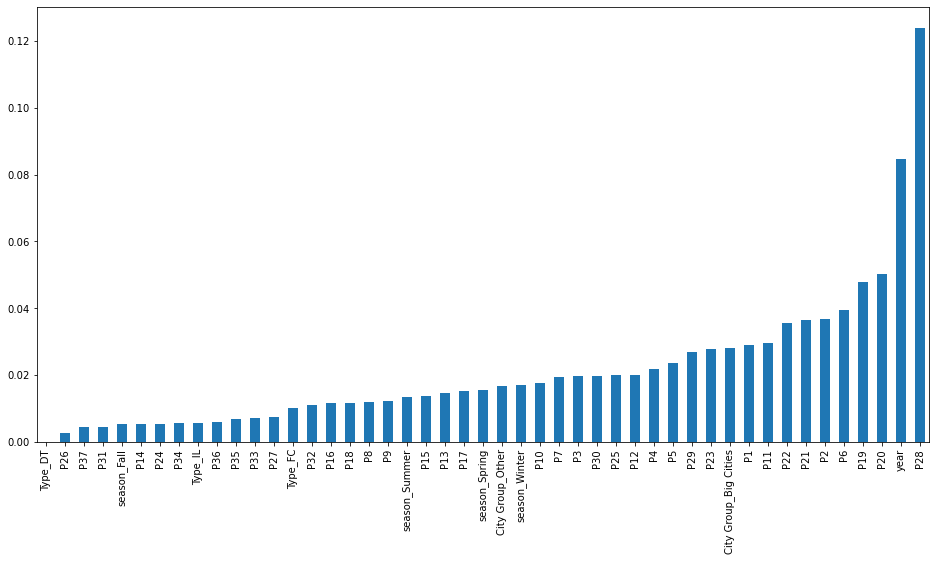

In [115]:
rf_feature.sort_values().plot(kind = 'bar', figsize = (16, 8))

#### _KNeighborRegressor_

In [116]:
knn = KNeighborsRegressor()

In [117]:
params_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
}

In [118]:
knn_regressor = GridSearchCV(knn, params_knn,cv=10, n_jobs=-1)

In [119]:
knn_regressor.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11]})

In [120]:
knn_regressor.best_params_

{'n_neighbors': 9}

In [121]:
knn_model = KNeighborsRegressor(n_neighbors = 9)

In [122]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

In [123]:
knn_model.score(X_train, y_train)

0.27060217393208885

In [124]:
knn_model.score(X_test, y_test)

0.19248824743143877

In [125]:
y_pred = knn_model.predict(X_test)

In [126]:
print('Explained variance score',explained_variance_score(y_test, y_pred),'\n',
   'Mean absolute error      :',mean_absolute_error(y_test, y_pred),'\n',
   'Mean squared error       :',mean_squared_error(y_test, y_pred),'\n',
   'R² score            :',r2_score(y_test, y_pred))

Explained variance score 0.20851149641227806 
 Mean absolute error      : 0.31728720379350556 
 Mean squared error       : 0.16218109545531684 
 R² score            : 0.19248824743143877


In [127]:
score_df_knn = pd.DataFrame(columns=['Method','KNN'])
score_df_knn['Method']=[
                    'Mean Absolute Error',
                    'Mean Squared Error',
                    'RMSE',
                    'R²']
score_df_knn['KNN']=[
                   mean_absolute_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred, squared = False),
                   r2_score(y_test, y_pred)]

In [128]:
score_df_knn

,Method,KNN
0,Mean Absolute Error,0.317287
1,Mean Squared Error,0.162181
2,RMSE,0.402717
3,R²,0.192488


In [129]:
pred_sub_knn = knn_model.predict(test.drop(columns = 'Id'))

In [130]:
submission_knn= pd.DataFrame(columns = ['Id', 'Prediction'])
submission_knn['Id'] = test['Id']
submission_knn['Prediction'] = pred_sub_knn
submission_knn.to_csv('submission_knn.csv', index = False)

#### _XGBoost Regressor_

In [131]:
xgb = XGBRegressor()

In [132]:
params_xgb = {
    'learning_rate': [.05,.1],
    'max_depth': [4, 9],
    'subsample': [.5, .7],
    'n_estimators': [100,200]
}

In [133]:
xgb_regressor = GridSearchCV(xgb, params_xgb, cv = 10, n_jobs=-1)

In [134]:
xgb_regressor.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_par

In [135]:
xgb_regressor.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.5}

In [136]:
xgb_model = XGBRegressor(learning_rate = 0.1, max_depth = 9, n_estimators = 200, subsample = 0.5)

In [137]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [138]:
xgb_model.score(X_train, y_train)

0.9997929370652401

In [139]:
xgb_model.score(X_test, y_test)

0.08680457990476842

In [140]:
y_pred = xgb_model.predict(X_test)

In [141]:
print('Explained variance score',explained_variance_score(y_test, y_pred),'\n',
   'Mean absolute error      :',mean_absolute_error(y_test, y_pred),'\n',
   'Mean squared error       :',mean_squared_error(y_test, y_pred),'\n',
   'R² score            :',r2_score(y_test, y_pred))

Explained variance score 0.08724762307217682 
 Mean absolute error      : 0.3426338420863468 
 Mean squared error       : 0.18340666018139262 
 R² score            : 0.08680457990476842


In [142]:
score_df_xgb = pd.DataFrame(columns=['Method','XGBoost'])
score_df_xgb['Method']=[
                    'Mean Absolute Error',
                    'Mean Squared Error',
                    'RMSE',
                    'R²']
score_df_xgb['XGBoost']=[
                   mean_absolute_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred),
                   mean_squared_error(y_test, y_pred, squared = False),
                   r2_score(y_test, y_pred)]

In [143]:
score_df_xgb

,Method,XGBoost
0,Mean Absolute Error,0.342634
1,Mean Squared Error,0.183407
2,RMSE,0.428260
3,R²,0.086805


In [144]:
pred_sub_xgb = xgb_model.predict(test.drop(columns = 'Id'))

In [145]:
submission_xgb= pd.DataFrame(columns = ['Id', 'Prediction'])
submission_xgb['Id'] = test['Id']
submission_xgb['Prediction'] = pred_sub_xgb
submission_xgb.to_csv('submission_xgb.csv', index = False)

In [146]:
score_df_lr.merge(score_df_ridge,on='Method').merge(score_df_lasso,on='Method').merge(score_df_rf, on = 'Method').merge(score_df_knn, on = 'Method').merge(score_df_xgb, on = 'Method')

,Method,Linear Regression,Ridge Regression,Lasso Regression,Random Forest,KNN,XGBoost
0,Mean Absolute Error,0.488084,0.377214,0.344108,0.332162,0.317287,0.342634
1,Mean Squared Error,0.386681,0.217586,0.201000,0.173868,0.162181,0.183407
2,RMSE,0.621837,0.466461,0.448330,0.416975,0.402717,0.428260
3,R²,-0.925315,-0.083376,-0.000794,0.134299,0.192488,0.086805
